In [1]:
! pip install --upgrade ..  > /dev/null

In [1]:
!tree -h ../data/design_matrix/sample_4_8_50

Too many parameters - ../data/design_matrix/sample_4_8_50


## Schema

In [2]:
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta


N_CUTS = 8
START_DATE = datetime.strptime("2018-01-01", "%Y-%m-%d")
END_DATE = datetime.strptime("2019-09-01", "%Y-%m-%d")

META = ["partition_id", "title"]
DEGREE = ["degree", "inDegree", "outDegree"]
SIGN = [f"sign_{i}" for i in range(N_CUTS)]
VECTOR = [f"fiedler_{i}" for i in range(N_CUTS)]
DATES = [(START_DATE + timedelta(t)).strftime("%Y-%m-%d")
         for t in range((END_DATE-START_DATE).days)]

SCHEMA = META + DEGREE + SIGN + VECTOR + DATES


data = pd.read_parquet(glob.glob("../data/design_matrix/sample_6_8_50/*.parquet")[0])
pretty_columns = META+DEGREE+SIGN[:1]+VECTOR[:1]+DATES[:3]
data.loc[:, pretty_columns].sample(5)

C:\Users\acmiy\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:751: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,partition_id,title,degree,inDegree,outDegree,sign_0,fiedler_0,2018-01-01,2018-01-02,2018-01-03
80372,ooxoxoxo,AtariWriter,87.0,33.0,54.0,False,-1.831282e-06,NaN,140.0,124.0
241130,oxxoxxox,Rathika_Sitsabaiesan,22.0,6.0,16.0,False,-1.831524e-06,NaN,NaN,NaN
11678,oxxxxoxx,Okół,84.0,57.0,27.0,False,-5.828698e-10,NaN,NaN,NaN
68567,oooxoxxx,Maniyur,85.0,19.0,66.0,False,-2.542738e-10,NaN,NaN,NaN
128846,xoxxxxxo,1753_House,269.0,113.0,156.0,True,3.699149e-10,NaN,122.0,132.0


# Data preprocessing and plotting

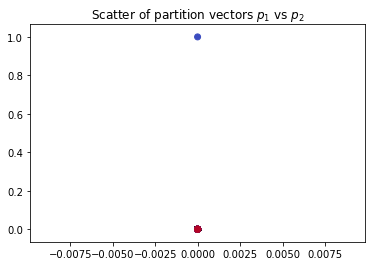

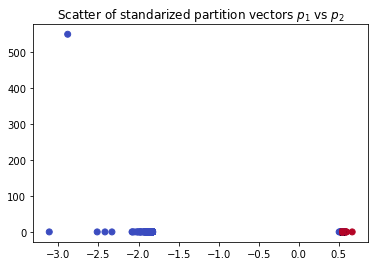

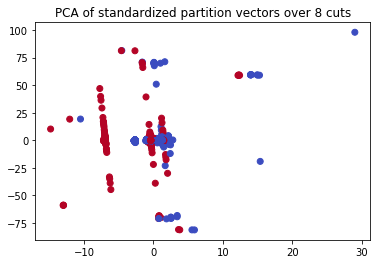

In [78]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sample_size = data.shape[0]
sample = data.fillna(0.0).sample(sample_size)

scaler = StandardScaler()
minmax = MinMaxScaler()
pca = PCA(n_components=2)

labels = sample[SIGN[0]].values.astype(int)
# labels = ([2, 1] * sample[SIGN[:2]].values.astype(int)).sum(axis=1)
z = sample[VECTOR]
z = scaler.fit_transform(z)
G = pca.fit_transform(z)

plt.title("Scatter of partition vectors $p_1$ vs $p_2$")
plt.scatter(sample[VECTOR].values[:, 0], sample[VECTOR].values[:, 1], c=labels, cmap="coolwarm")
plt.show()

plt.title("Scatter of standarized partition vectors $p_1$ vs $p_2$")
plt.scatter(z[:, 0], z[:, 1], c=labels, cmap="coolwarm")
plt.show()

plt.title("PCA of standardized partition vectors over 8 cuts")
plt.scatter(G[:, 0], G[:, 1], c=labels, cmap="coolwarm")
plt.savefig("../images/cluster_pca.png")
plt.show()

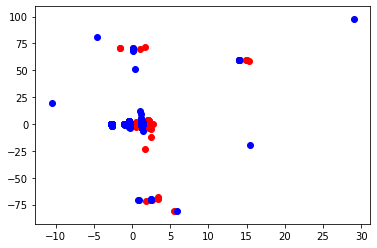

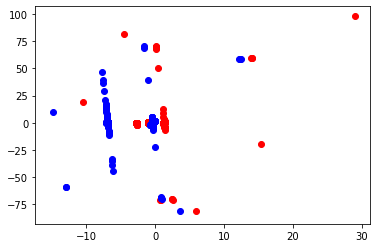

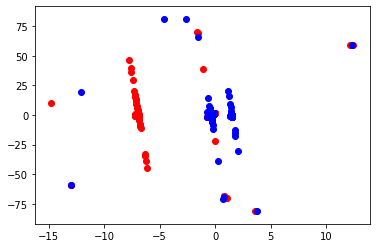

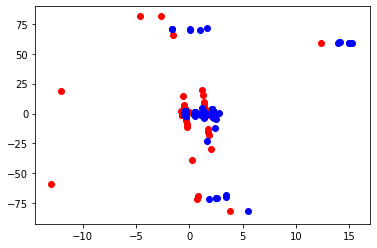

In [79]:
labels_quad = ([2, 1] * sample[SIGN[:2]].values.astype(int)).sum(axis=1)
plt.scatter(G[labels_quad==0, 0], G[labels_quad==0, 1], c='red', cmap="coolwarm")
plt.scatter(G[labels_quad==1, 0], G[labels_quad==1, 1], c='blue', cmap="coolwarm")
plt.show()

plt.scatter(G[labels_quad==1, 0], G[labels_quad==1, 1], c='red', cmap="coolwarm")
plt.scatter(G[labels_quad==2, 0], G[labels_quad==2, 1], c='blue', cmap="coolwarm")
plt.show()

plt.scatter(G[labels_quad==2, 0], G[labels_quad==2, 1], c='red', cmap="coolwarm")
plt.scatter(G[labels_quad==3, 0], G[labels_quad==3, 1], c='blue', cmap="coolwarm")
plt.show()

plt.scatter(G[labels_quad==3, 0], G[labels_quad==3, 1], c='red', cmap="coolwarm")
plt.scatter(G[labels_quad==0, 0], G[labels_quad==0, 1], c='blue', cmap="coolwarm")
plt.show()

## Gaussian Mixture Model

See [an example of contours with mixture models](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.htmlsphx-glr-auto-examples-mixture-plot-gmm-pdf-py) and [GMM covariances](https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_covariances.html#sphx-glr-auto-examples-mixture-plot-gmm-covariances-py)

In [5]:
pd.DataFrame(sample.groupby(by=SIGN[:3]).count()["id"])

id
sign_0 sign_1 sign_2       
False  False  False   52100
              True    41036
       True   False   37871
              True    43183
True   False  False   33330
              True    31263
       True   False   33902
              True    29663

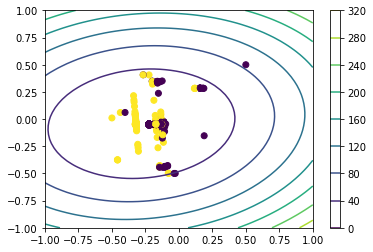

In [82]:
from sklearn.mixture import GaussianMixture

estimator = GaussianMixture(
    n_components=2, 
    tol=0.001, 
    init_params='kmeans',
    covariance_type='full',
)
zz = MinMaxScaler().fit_transform(G)-0.5
estimator.fit(zz[:,:2])

# display predicted scores by the model as a contour plot
x = np.linspace(-1, 1)
y = np.linspace(-1, 1)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -estimator.score_samples(XX)
Z = Z.reshape(X.shape)

fig = plt.figure()
CS = plt.contour(X, Y, Z)
CB = plt.colorbar(CS)
plt.scatter(zz[:, 0], zz[:, 1], c=labels)
plt.show()

## Logistic Regression

In [76]:
G.shape, labels.shape

((302348, 3), (302348,))

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn import metrics, cross_validation

# https://scikit-learn.org/stable/auto_examples/linear_model/plot_iris_logistic.html#sphx-glr-auto-examples-linear-model-plot-iris-logistic-py

zz = MinMaxScaler().fit_transform(G)-0.5
logreg = LogisticRegression()
predicted = cross_validation.cross_val_predict(logreg, G, labels, cv=10)

print(metrics.accuracy_score(labels, predicted))
print(metrics.classification_report(labels, predicted) )

0.6509584981544445
             precision    recall  f1-score   support

          0       0.93      0.42      0.58    174190
          1       0.55      0.96      0.70    128158

avg / total       0.77      0.65      0.63    302348



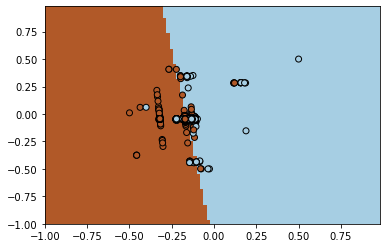

In [81]:
logreg.fit(zz, labels)
x_min, x_max = zz[:, 0].min() - .5, zz[:, 0].max() + .5
y_min, y_max = zz[:, 1].min() - .5, zz[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
plt.pcolormesh(xx, yy, Z.reshape(xx.shape), cmap=plt.cm.Paired)
plt.scatter(zz[:, 0], zz[:, 1], c=labels, edgecolors="k", cmap=plt.cm.Paired)

plt.show()